In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [201]:
# import data

train = pd.read_csv('titanictrain.csv')
test = pd.read_csv('titanictest.csv')

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

In [202]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [203]:
# number of nans in each column

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ideas: due to the large number of missing values, delete the cabin feature. Replace the 2 Embarked NAs with the most frequent. 

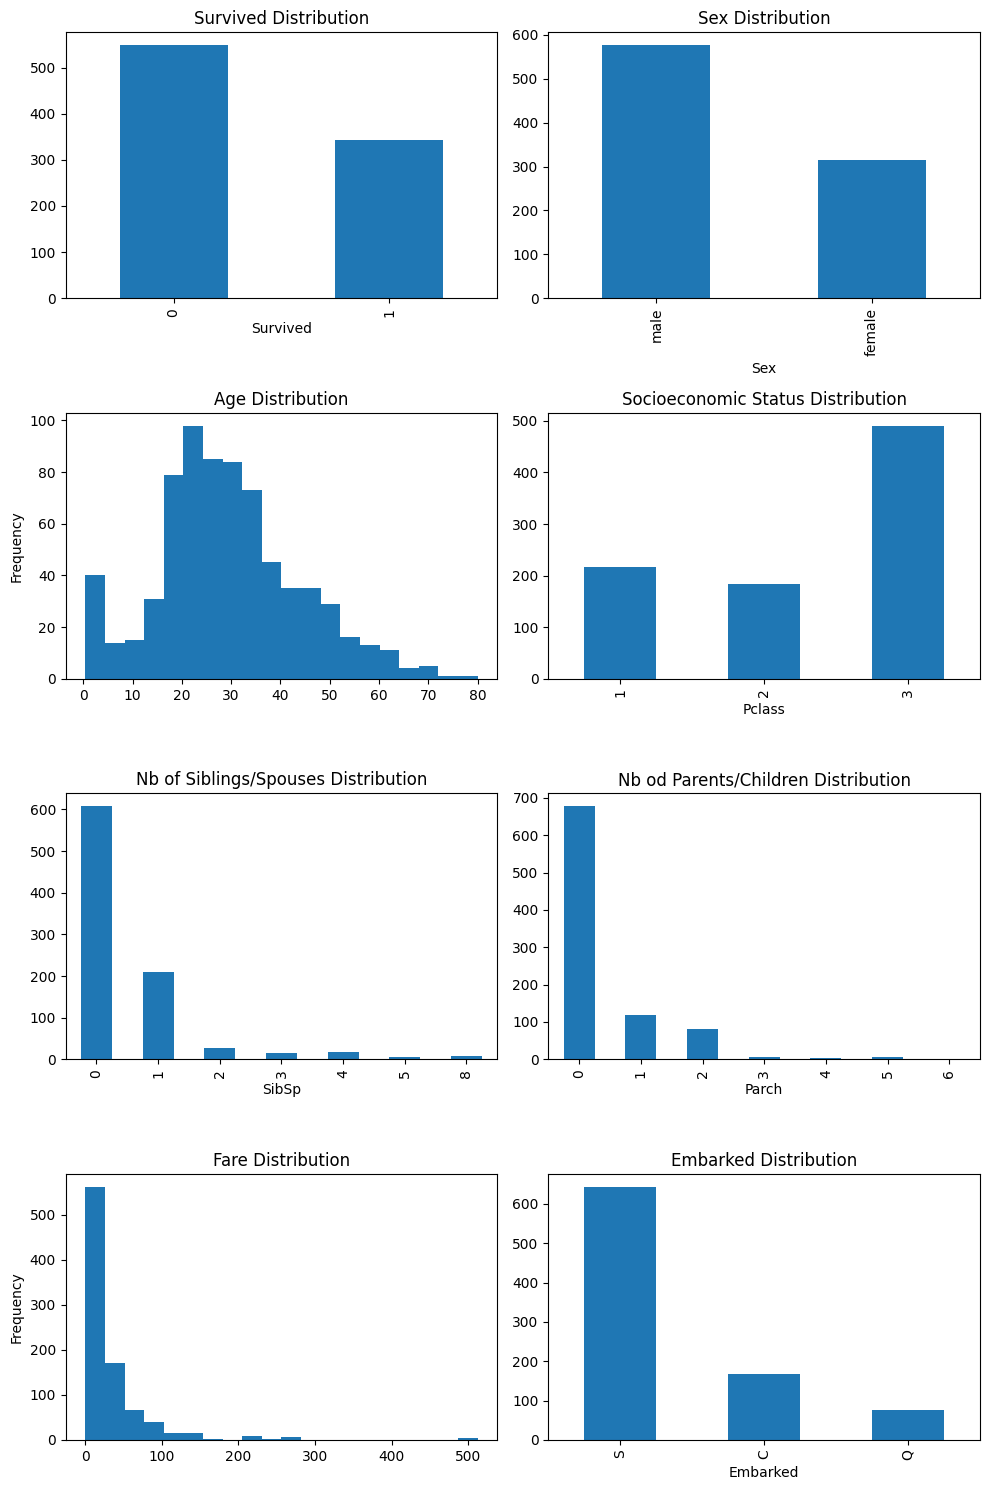

In [204]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 15))

# Histograms of the data
train['Survived'].value_counts().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Survived Distribution')

train['Sex'].value_counts().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution')

train['Age'].plot(kind='hist', bins=20, ax=axs[1, 0])
axs[1, 0].set_title('Age Distribution')

train['Pclass'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Socioeconomic Status Distribution')

train['SibSp'].value_counts().sort_index().plot(kind='bar', ax=axs[2, 0])
axs[2, 0].set_title('Nb of Siblings/Spouses Distribution')

train['Parch'].value_counts().sort_index().plot(kind='bar', ax=axs[2, 1])
axs[2, 1].set_title('Nb od Parents/Children Distribution')

train['Fare'].plot(kind='hist', bins=20, ax=axs[3, 0])
axs[3, 0].set_title('Fare Distribution')

train['Embarked'].value_counts().plot(kind='bar', ax=axs[3, 1])
axs[3, 1].set_title('Embarked Distribution')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [205]:
survived = train[train['Survived'] == 1]
died = train[train['Survived'] == 0]

list_surv=survived['Sex'].value_counts().tolist()
list_died=died['Sex'].value_counts().tolist()
keysdied=died['Sex'].value_counts().keys().tolist()
keyssurv=survived['Sex'].value_counts().keys().tolist()
#print(keyssurv)
#print(list_surv)
#print(keysdied)
#print(list_died)

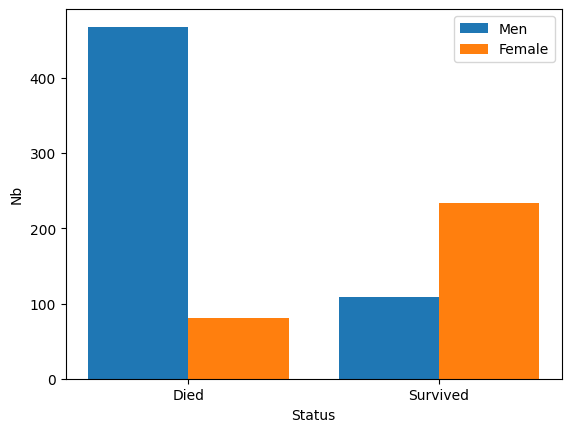

In [206]:
# survival distribution by sex

plt.figure()

status = ('Died','Survived')
y_pos = np.arange(len(status))

plt.bar(y_pos-0.2, [468,109], width=0.4)
plt.bar(y_pos+0.2, [81,233], width=0.4)
plt.xticks(y_pos, status)
plt.xlabel('Status')
plt.ylabel('Nb')
plt.legend(['Men', 'Female'])  

to do:

- test decision forests with tf
- test random forests with sklearn
- test svms
- test preprocessing and check results

## Preprocessing

At this stage preprcessing consisted in transforming string categorical variables to numeric codes and dropping tickets and cabins

In [207]:
print(train['Name'].head(10))

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object


In [208]:
## divde names into title, first name and last name in a list

def split_nametitle(name):
    return name.split(',')[1].split('.')[0].strip()

def split_namefirst(name):
    return name.split(',')[0].strip()

def split_namelast(name):
    return name.split(',')[1].split('.')[1].strip()

train['Title'] = train['Name'].apply(split_nametitle)


#print train set with new columns
print(train.head(10))

test['Title'] = test['Name'].apply(split_nametitle)


#print test set with new columns
print(test.head(10))

#drop name columns from train and test

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)




   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [209]:
# mr --> 0, miss --> 1, mrs --> 2, master --> 3, other --> 4

def title_to_num(title):
    if title == 'Mr':
        return 0
    elif title == 'Miss':
        return 1
    elif title == 'Mrs':
        return 2
    elif title == 'Master':
        return 3
    else:
        return 4
    
train['Title'] = train['Title'].apply(title_to_num)
test['Title'] = test['Title'].apply(title_to_num)

def sex_to_num(sex):
    if sex=='male':
        return 0
    else:
        return 1

train['Sex'] = train['Sex'].apply(sex_to_num)
test['Sex'] = test['Sex'].apply(sex_to_num)

# embarked: C --> 0, Q --> 1, S --> 2

def embarked_to_num(embarked):
    if embarked == 'C':
        return 0
    elif embarked == 'Q':
        return 1
    else:
        return 2

train['Embarked'] = train['Embarked'].apply(embarked_to_num)
test['Embarked'] = test['Embarked'].apply(embarked_to_num)

# drop ticket and cabin

train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

print(train.head(10))
print(test.head(10))


   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  \
0            1         0       3    0  22.0      1      0   7.2500         2   
1            2         1       1    1  38.0      1      0  71.2833         0   
2            3         1       3    1  26.0      0      0   7.9250         2   
3            4         1       1    1  35.0      1      0  53.1000         2   
4            5         0       3    0  35.0      0      0   8.0500         2   
5            6         0       3    0   NaN      0      0   8.4583         1   
6            7         0       1    0  54.0      0      0  51.8625         2   
7            8         0       3    0   2.0      3      1  21.0750         2   
8            9         1       3    1  27.0      0      2  11.1333         2   
9           10         1       2    1  14.0      1      0  30.0708         0   

   Title  
0      0  
1      2  
2      1  
3      2  
4      0  
5      0  
6      0  
7      3  
8      2  
9      2 

## Sklearn Random Forests

In [210]:
# get vector of survived column
y = train['Survived'].values

# drop survived column
train = train.drop(columns=['Survived'])

In [211]:
# check sizes
#print(y.shape)
#print(train.shape)

Default RF

In [212]:
model_defRF = RandomForestClassifier(random_state=0)
model_defRF.fit(train, y)

# cross validation

scores = cross_val_score(model_defRF, train, y, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.80


Hyperparameter tuning RF

In [213]:
# use random search to find best hyperparameters (not all parameters are attempted)

# nb of trees

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)] # 10 values between 200 and 2000

# nb of features to consider at each split

max_features = ['sqrt', 'log2',None] 

# max depth of the tree

max_depth = [int(x) for x in np.linspace(10, 110, num=11)] # 11 values between 10 and 110

# min number of samples required to split a node

min_samples_split = [2, 5, 10, 20]

# min number of samples required at each leaf node

min_samples_leaf = [1, 2, 4, 8]

# method of selecting samples for training each tree

bootstrap = [True, False] # if false the whole dataset is used to build each tree

# create the random grid

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}


In [214]:
rf = RandomForestClassifier()

# searches for the best hyperparameters across 100 different combinations, and uses 3 fold cross validation
model_randomRF = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

model_randomRF.fit(train, y)

print(model_randomRF.best_params_)
print(model_randomRF.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60, 'bootstrap': True}
0.8372615039281706


In [216]:
# train with best hyperparameters

model_bestrandomRF = RandomForestClassifier(n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features='log2', max_depth=60, bootstrap=True, random_state=0)
model_bestrandomRF.fit(train, y)

# cross validation

scores = cross_val_score(model_bestrandomRF, train, y, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.81


Using GridSearch based on the RandomSearch results